<a href="https://colab.research.google.com/github/utkarsh0702/Tensorflow/blob/master/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import tensorflow as tf
import os
from tensorflow import keras
import zipfile
from google.colab import files
import pandas as pd
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib as mpl

In [55]:
mpl.rcParams['figure.figsize'] = (10,8)

In [56]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
local_zip= '/content/drive/My Drive/datasets/dog-breed-identification.zip'
zip_ref= zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [58]:
df= pd.read_csv('labels.csv')
df

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


# Data Preprocessing

**Choosing specific Dog Breeds**

In [60]:
breeds={'beagle':0, 'chihuahua':1, 'doberman':2,'french_bulldog':3, 'golden_retriever':4,
                   'malamute':5, 'pug':6, 'saint_bernard':7, 'scottish_deerhound':8,'tibetan_mastiff':9}
df1 = df.loc[df['breed'].apply(lambda x: any([k in x for k in breeds]))]
df1.head(10)

,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
20,008b1271ed1addaccf93783b39deab45,doberman
25,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
82,01f429667104c0c5a5f321700f15435c,malamute
84,0206c12e8984e3c8a166cc272de25d6f,chihuahua
92,023e4e28415506e0deddcbd8f8bdab29,pug
97,02508e76981e1ba059d785704b4c480c,pug


In [61]:
# added .jpg at the end of each object in id column
df1.id = df1.id + '.jpg'

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [62]:
df1['breed'].value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

**Test Data Segregation**

In [69]:
test= df1.iloc[-5:]
df1.drop(df1.index[[-1,-2,-3,-4,-5]], inplace=True)
test

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,breed
10158,fe50bac6c389d137ea01c9cfc7346ca8.jpg,scottish_deerhound
10161,fe624532170510bd80627c0500bafc97.jpg,tibetan_mastiff
10170,feb16cf86c9dac6d476e3c372ba5c279.jpg,pug
10172,febcab8eb2da444bf83336cffec7eb92.jpg,golden_retriever
10198,ff6f47aa8e181b6efa4d0be7b09b5628.jpg,golden_retriever


In [71]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    df1,
    directory="train/",
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    batch_size=32, 
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df1,
    directory="train/",
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    batch_size=32,
    subset="validation")

Found 753 validated image filenames belonging to 10 classes.
Found 83 validated image filenames belonging to 10 classes.


# Transfer Learning with ResNet50

In [80]:
feature_extractor = keras.applications.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')
feature_extractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Finding a suitable learning rate

In [93]:
keras.backend.clear_session()

model= keras.Sequential([
                         feature_extractor,
                         keras.layers.GlobalAveragePooling2D(),
                         keras.layers.Dense(256, activation="relu"),
                         keras.layers.Dropout(0.3),
                         keras.layers.Dense(32, activation="relu"),
                         keras.layers.Dropout(0.4),
                         keras.layers.Dense(10, activation= "softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

In [94]:
num_layers= 6
feature_extractor.trainable= True;
for Layers in model.layers[-num_layers:]:
  Layers.trainable= True

In [95]:
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5*10**(x/20))
# a check point callback to save our best model
checkpoint = keras.callbacks.ModelCheckpoint('dog_breed_classifier_model.h5', 
                                             monitor='val_accuracy', 
                                             verbose=1, save_best_only=True, 
                                             mode='max', save_weights_only=True)

model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=1e-5),
    loss= keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [96]:
history = model.fit(train_generator,
                    validation_data=validation_generator, verbose=1,
                    epochs=50, callbacks=[lr_schedular, checkpoint])

Epoch 1/50
24/24 [==============================] - 15s 420ms/step - loss: 2.4389 - accuracy: 0.1420 - val_loss: 2.1443 - val_accuracy: 0.1687

Epoch 00001: val_accuracy improved from -inf to 0.16867, saving model to dog_breed_classifier_model.h5
Epoch 2/50
24/24 [==============================] - 9s 390ms/step - loss: 2.0671 - accuracy: 0.2345 - val_loss: 2.0104 - val_accuracy: 0.2771

Epoch 00002: val_accuracy improved from 0.16867 to 0.27711, saving model to dog_breed_classifier_model.h5
Epoch 3/50
24/24 [==============================] - 9s 380ms/step - loss: 1.7913 - accuracy: 0.3548 - val_loss: 1.9095 - val_accuracy: 0.3855

Epoch 00003: val_accuracy improved from 0.27711 to 0.38554, saving model to dog_breed_classifier_model.h5
Epoch 4/50
24/24 [==============================] - 9s 370ms/step - loss: 1.5428 - accuracy: 0.4544 - val_loss: 1.8190 - val_accuracy: 0.4819

Epoch 00004: val_accuracy improved from 0.38554 to 0.48193, saving model to dog_breed_classifier_model.h5
Epoch 

In [97]:
val_acc= max(history.history['val_accuracy'])
val_accuracy= history.history['val_accuracy']
index=val_accuracy.index(val_acc)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index: 
    lr=i
    break
  count+=1
print(lr)
print(val_acc)

0.00019952623
0.6987951993942261


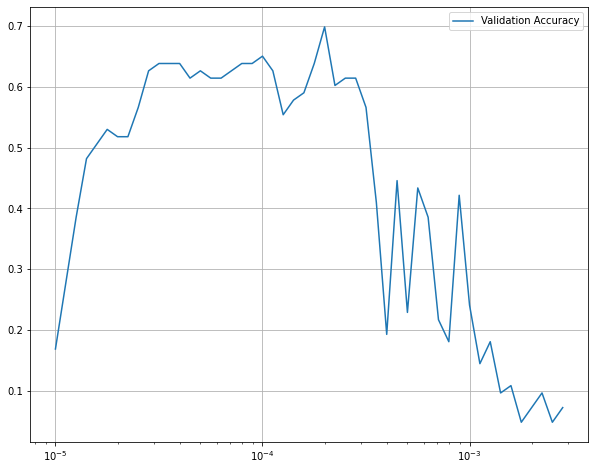

In [98]:
lrs= 1e-5*(10**(np.arange(50)/20))
plt.semilogx(lrs, history.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='best')
plt.grid(True)

# Model Training

In [99]:
keras.backend.clear_session()

model.load_weights('dog_breed_classifier_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

In [101]:
num_layers= 6
for Layers in model.layers[-num_layers:]:
  Layers.trainable= True

In [102]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=lr),
    loss= keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [103]:
# a check point callback to save our best model
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', 
                                             verbose=1, save_best_only=True, 
                                             mode='max')

In [104]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator, verbose=1,
                              epochs=50, callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
24/24 [==============================] - 14s 399ms/step - loss: 0.1232 - accuracy: 0.9733 - val_loss: 2.4013 - val_accuracy: 0.6145

Epoch 00001: val_accuracy improved from -inf to 0.61446, saving model to model.h5
Epoch 2/50
24/24 [==============================] - 9s 368ms/step - loss: 0.0863 - accuracy: 0.9731 - val_loss: 2.8651 - val_accuracy: 0.5663

Epoch 00002: val_accuracy did not improve from 0.61446
Epoch 3/50
24/24 [==============================] - 9s 377ms/step - loss: 0.1172 - accuracy: 0.9734 - val_loss: 2.5573 - val_accuracy: 0.5542

Epoch 00003: val_accuracy did not improve from 0.61446
Epoch 4/50
24/24 [==============================] - 9s 385ms/step - loss: 0.0910 - accuracy: 0.9791 - val_loss: 2.8469 - val_accuracy: 0.5904

Epoch 00004: val_accuracy did not improve from 0.61446
Epoch 5/50
24/24 [==============================] - 9s 385ms/step - loss: 0.1306 - accuracy: 0.9647 - val_loss: 4.4467 - val_accuracy: 0.5783

Epoch 00005: val_accuracy did not imp

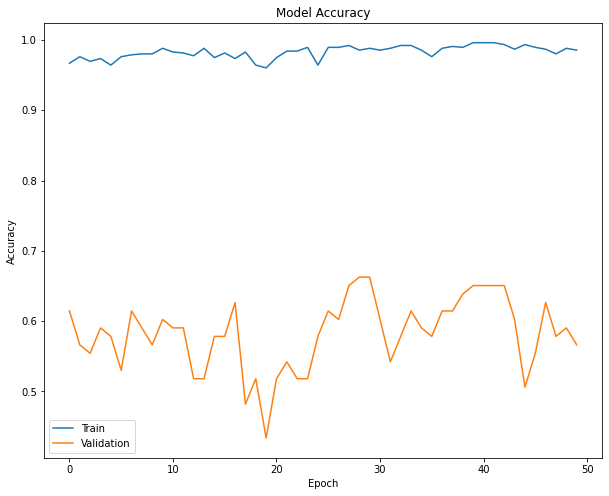

In [105]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [107]:
model= keras.models.load_model('model.h5')